# Allan Pereira Fenelon

# 1 - Bibliotecas e Leitura dos Dados

In [1]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from pmdarima import model_selection
import time
import auxiliar as ax
from sklearn.tree import DecisionTreeRegressor
from skopt.space import Real, Integer
from skopt import gp_minimize
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH = '../bds/'
tickers = ['TSLA', 'NIO', 'LI', 'RIVN', 'BYDDY']

times_series = {}
for name in tickers:
    serie = pd.read_csv(DATA_PATH + name + '.csv' ,sep=',',usecols=[0,4])
    times_series[name] = serie

# 2 - Séries Temporais Utilizadas

As séries temporais a seguir são relativas às séries temporais sobre o preço de fechamento das ações financeiras, mais específico em séries temporais financeiras de carros elétricos. Há 5 empresas nesse trabalho, onde se destacam duas mais populares no mundo hoje em dia que é a ação da empresa Tesla Inc. e da empresa BYD.

Os registros de cada série temporal são diárias, e o valor em dólar. Temos observações de 5 anos corridos, do período de 01/10/2020 a 01/10/2024. Passando pelo período da pandemia até os dias atuais.

$\textbf{1. Tesla, Inc. (TSLA)} \\$
A Tesla é uma das líderes globais na produção de veículos elétricos e soluções de armazenamento de energia. Fundada por Elon Musk, a empresa é conhecida por seus carros elétricos de alto desempenho, como o Model S, Model 3, Model X e Model Y. Além de veículos elétricos, a Tesla também produz baterias e sistemas de energia solar.

$\textbf{2. BYD Company Limited (BYDDY)} \\$
A BYD é uma das maiores fabricantes de veículos elétricos e baterias do mundo. Com sede na China, a empresa produz uma ampla gama de veículos elétricos, incluindo ônibus e carros de passageiros, além de baterias e tecnologias de energia renovável. A BYD tem um forte foco em soluções sustentáveis e é uma das líderes no mercado de veículos elétricos na China. 

$\textbf{3. Li Auto Inc. (LI)} \\$
Li Auto é uma fabricante chinesa de veículos elétricos e híbridos plug-in. A empresa é conhecida por seus SUVs híbridos, como o Li ONE. Li Auto se concentra em fornecer veículos elétricos com tecnologias avançadas e uma extensa rede de recarga e suporte. 

$\textbf{4. NIO Inc. (NIO)} \\$
A NIO é uma fabricante de veículos elétricos premium com sede na China. A empresa é conhecida por seus SUVs elétricos e sedans, como o ES8, ES6 e o EC6. A NIO também se destaca por seu modelo de substituição de bateria, oferecendo um serviço onde os clientes podem trocar as baterias de seus veículos em estações de troca rápida. 

$\textbf{5. Rivian Automotive Inc. (RIVN)} \\$
A Rivian é uma fabricante americana de veículos elétricos focada em modelos voltados para aventuras e transporte sustentável. Fundada em 2009 e com sede na Califórnia, a empresa desenvolve caminhonetes e SUVs, como os modelos R1T e R1S, projetados para oferecer experiências conectadas e melhorar ao longo do tempo por meio de atualizações de software. A Rivian também fabrica vans elétricas para frotas, como as usadas pela Amazon.


Plotaremos cada uma das Séries temporais a seguir:

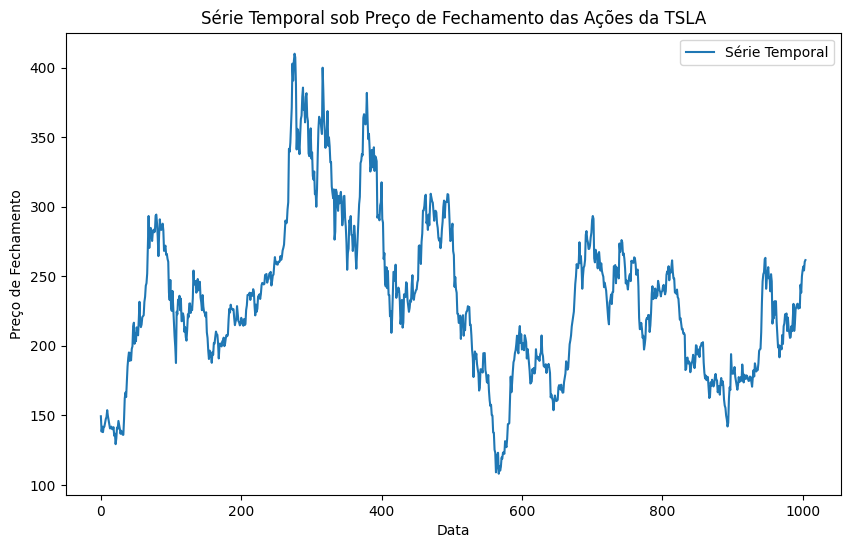

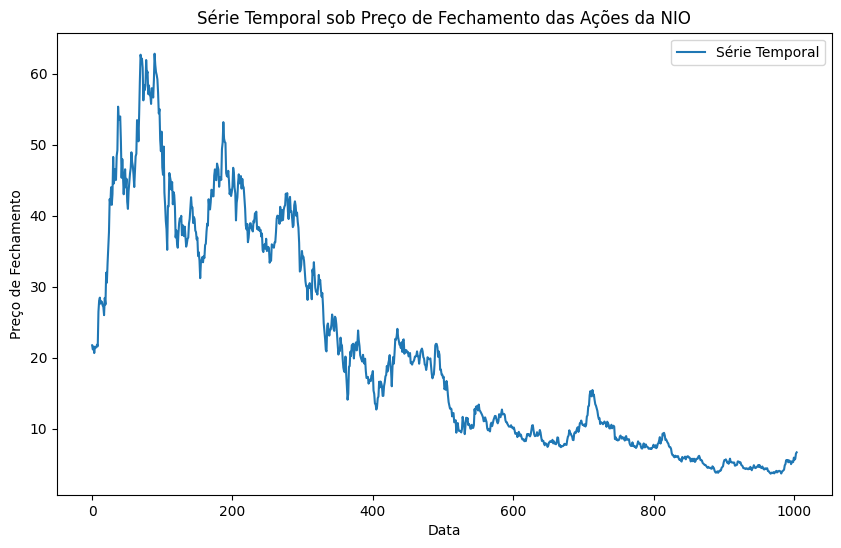

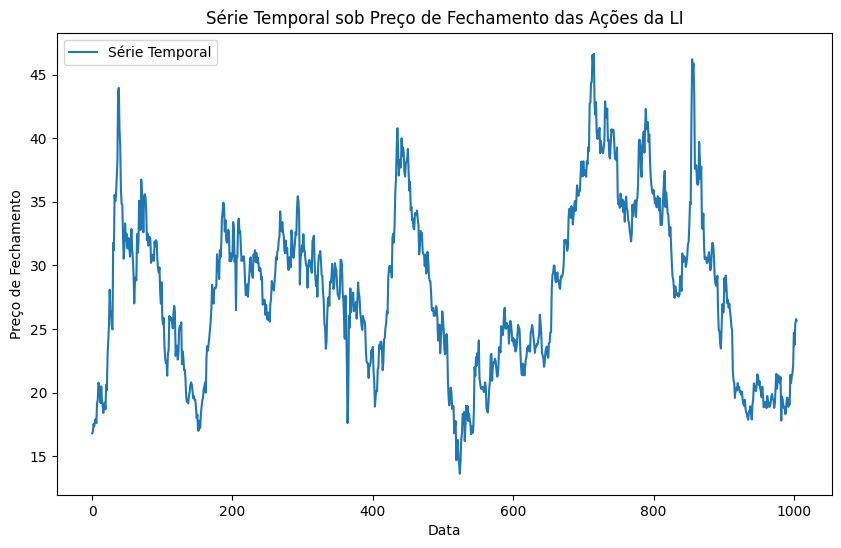

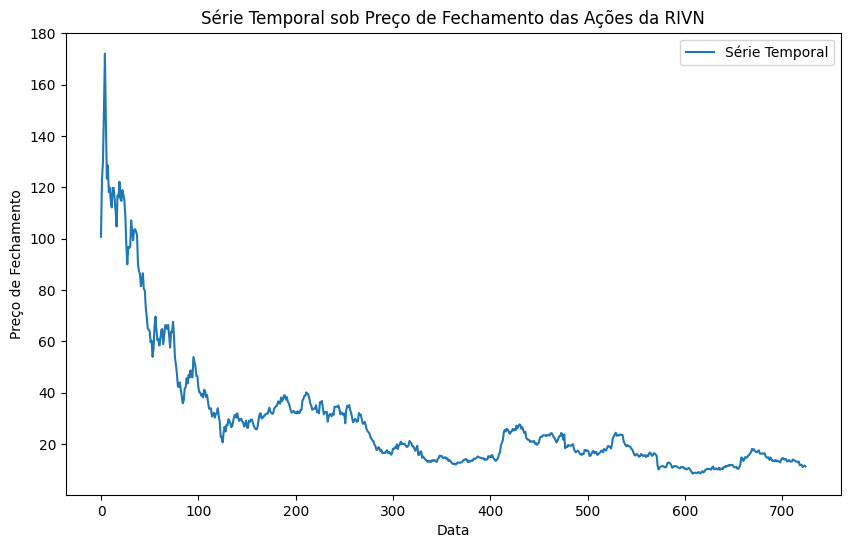

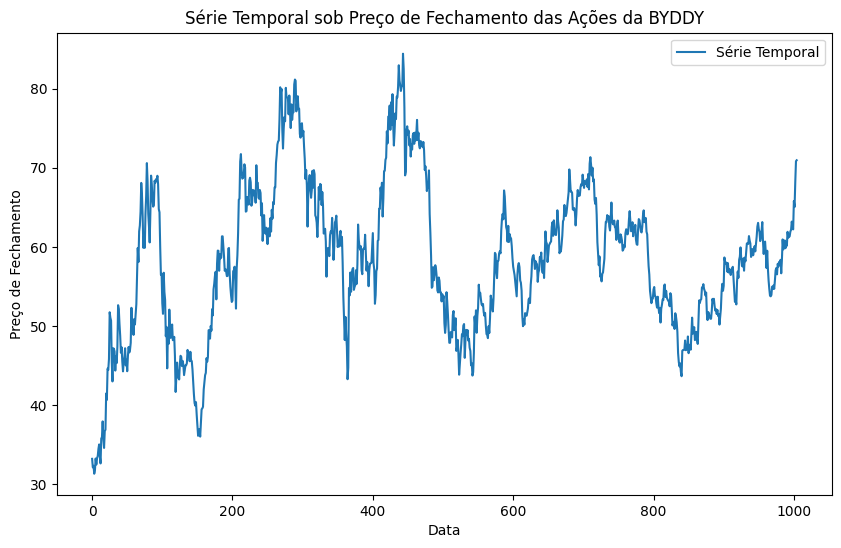

In [2]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(times_series[name].index,times_series[name]['Close'], label='Série Temporal')
    plt.title(f'Série Temporal sob Preço de Fechamento das Ações da {name}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

# 3 - Pré-Processamento

Nesta etapa, vamos se dedicar ao estudo de Lags relevantes, que estão associado ao teste de associação. Queremos fazer estudo em períodos diferentes do tempo para achar uma associação entre esse período do tempo na influencia nos demais.

Usaremos a autocorrelação parcial para fazer o estudo de Lags significativos nas nossas séries temporais. A Autocorrelação Parcial (PACF) mede a correlação entre uma variável(ou período de tempo neste caso) e suas defasagens, removendo o efeito das defasagens intermediárias.



$$
R_k = \frac{1}{N} \sum_{t=1}^{N-k} (X_t - \mu)(X_{t+k} - \mu)
$$

Onde:
\begin{align*}
R_k & : \text{ autocorrelação no lag } k \\
N & : \text{ número total de observações na série} \\
X_t & : \text{ valor da série no tempo } t \\
X_{t+k} & : \text{ valor da série no tempo } t+k \\
\mu & : \text{ média da série}
\end{align*}

Para obter os lags significantes aplicamos um teste de hipótese, onde :

$$
(H_0): \text{O lag é significante} \\

(H_a): \text{O lag não é significante}
$$

Vamos aceitar ($H_0$) quando nossa autocorrelação parcial estiver fora do nosso intervalo de confiança então vamos ter que o nosso lag no instante i é significante, caso contrário, aceitamos ($H_a$).

significantLags: [1, 5, 8, 10, 19, 25]
          Date       Close   (Close-1)   (Close-5)   (Close-8)  (Close-10)  \
25  2020-11-05  146.029999  140.326660  136.943329  140.093338  141.929993   
26  2020-11-06  143.316666  146.029999  129.346664  141.559998  140.210007   

    (Close-19)  (Close-25)  
25  144.666672  149.386673  
26  147.433334  138.363327  
significantLags: [1, 2, 3, 4, 5, 6, 8, 13, 19, 21, 22, 26]
          Date      Close  (Close-1)  (Close-2)  (Close-3)  (Close-4)  \
26  2020-11-06  41.630001  42.349998  37.709999  35.500000      33.32   
27  2020-11-09  44.020000  41.630001  42.349998  37.709999      35.50   

    (Close-5)  (Close-6)  (Close-8)  (Close-13)  (Close-19)  (Close-21)  \
26      30.58      31.99  28.440001   27.959999   21.850000   21.440001   
27      33.32      30.58  27.510000   27.860001   21.620001   21.469999   

    (Close-22)  (Close-26)  
26   21.559999       21.76  
27   21.440001       21.18  
significantLags: [1, 5]
         Date  Close  (

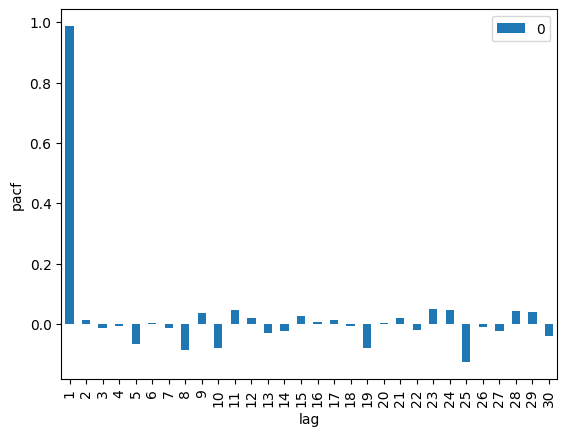

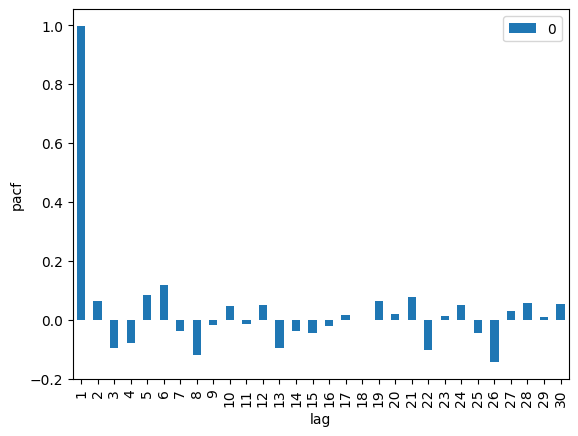

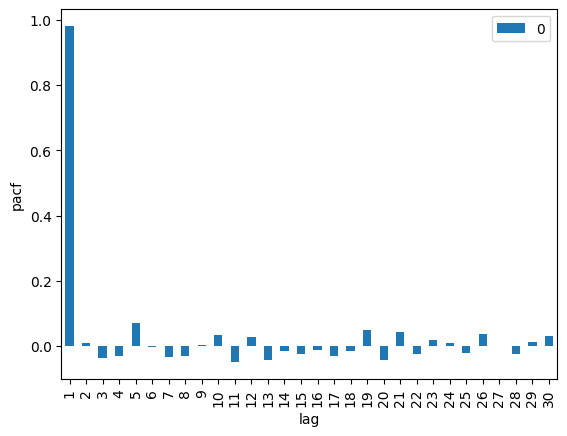

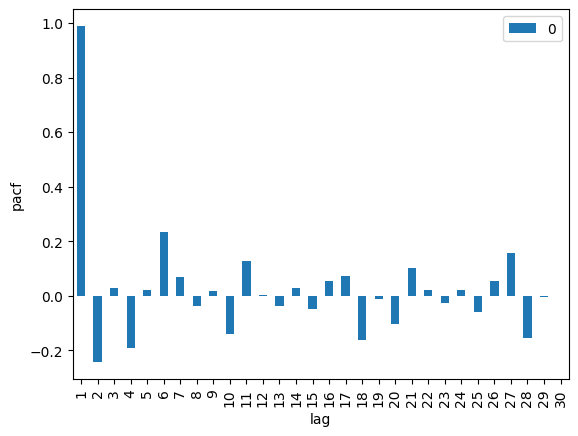

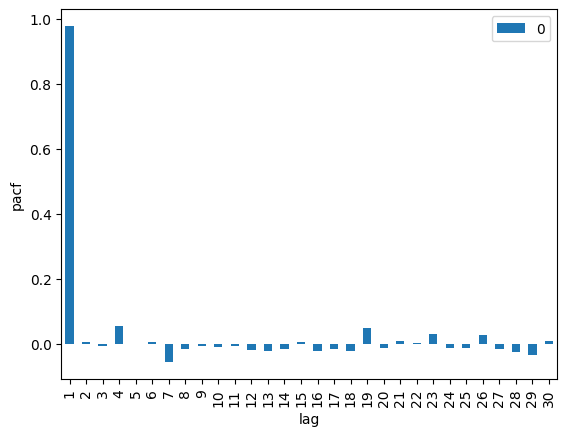

In [3]:
n_lags_significantes = {
    'TSLA': 30, 'NIO': 30, 'LI': 30, 'RIVN': 30, 'BYDDY': 30
}
for name in tickers:
    lags = ax.getSignificantLags(y=times_series[name]['Close'], nLags =n_lags_significantes[name], alpha=0.05)
    times_series[name] = ax.appendLagVariables(yNm='Close', significantLags = lags, df = times_series[name], dropna=True)


Na cédula abaixo, estamos inicialmente, para cada série temporal que tem o nome em tickers, pegando nossas features __X__ e o target __y__ de cada uma, após estamos dividindo a série em treino (80%) e teste (20%). 

In [4]:
X = {}
y = {}
for name in tickers:
    times_series[name] = times_series[name].dropna()
    X[name] = times_series[name].drop('Close', axis=1)
    X[name] = X[name].drop('Date', axis=1)
    y[name] = times_series[name]['Close']
    
X_train = {}
X_test = {}
y_train = {}
y_test = {}

for name in tickers:
    X_train[name], X_test[name], y_train[name], y_test[name] = train_test_split(X[name], y[name], 
                                                                                test_size=0.2, shuffle=False)

# 4 - Processamento

Nesta seção abordaremos a modelagem de cada uma das séries temporais. Abordaremos modelos que foram visto em sala de aula da diciplina de __Séries Temporais__ e __Estatística Computacional__.

Inicialmente, começaremos com um modelo base __(Random Walk)__ e proseguiremos com outros modelos, adotaremos a estratégia, para cada modelo:
- Modelar os resíduos do Random Walk;
- Modelar cada uma das Séries temporais;
- Comparar as modelagem de ambos.

Nas modelagens, adotaremos a estratégia de prever em N-Step-Ahead. Onde N é quantidade de observações da série de teste.

### Funções Utilitárias 

A função a seguir é uma função que ajuda a treinar um modelo qualquer, sem a necessidade de repetição do mesmo procedimento em ambas subseções dessa seção. Generalizamos para a maioria dos modelos que iremos utilizar nesse seção.

In [5]:
def fit_and_train_model(X: dict, y: dict, times_series_names: list, models):
    tempos = {}
    for name in times_series_names:
        start_time = time.time()
        models[name].fit(X[name], y[name])
        end_time = time.time()
        tempos[name] = end_time - start_time
    
    return tempos
    

A função a seguir é uma função que ajuda a dar o predict em um modelo qualquer, sem a necessidade de repetição do mesmo procedimento em ambas subseções dessa seção. Generalizamos para a maioria dos modelos que iremos utilizar nesse seção.

In [6]:
def predict_models(X: dict, times_series_names: list, models):
    tempos = {}
    previsoes = {}
    for name in times_series_names:
        start_time = time.time()
        previsoes[name] = models[name].predict(X[name])
        end_time = time.time()
        tempos[name] = end_time - start_time
    return tempos, previsoes

Essa função ajuda a construir a tabela de métricas, útil na seção de desempenho de cada subseção e na seção de análise de desempenho.

In [7]:
def get_table_metrics(tickers: dict, model_name, rw: bool, metricas: dict, tempo_fit: dict, tempo_predict: dict):
    metricas_table = {
        'TS': [ticker for ticker in tickers],
        'Model': model_name,
        'rw': rw,
        'MSE': [metricas[ticker][metricas[ticker]['Métrica'] == 'MSE']['Valor'].values[0] for ticker in tickers],
        'MAE': [metricas[ticker][metricas[ticker]['Métrica'] == 'MAE']['Valor'].values[0] for ticker in tickers],
        'MAPE': [metricas[ticker][metricas[ticker]['Métrica'] == 'MAPE']['Valor'].values[0] for ticker in tickers],
        'RMSE': [metricas[ticker][metricas[ticker]['Métrica'] == 'RMSE']['Valor'].values[0] for ticker in tickers],
        'R^2': [metricas[ticker][metricas[ticker]['Métrica'] == 'R^2']['Valor'].values[0] for ticker in tickers],
        'U de THEIL': [metricas[ticker][metricas[ticker]['Métrica'] == 'THEIL']['Valor'].values[0] for ticker in tickers],
        'ARV': [metricas[ticker][metricas[ticker]['Métrica'] == 'ARV']['Valor'].values[0] for ticker in tickers],
        'WPOCID': [metricas[ticker][metricas[ticker]['Métrica'] == 'WPOCID']['Valor'].values[0] for ticker in tickers],
        'Tempo Fit (s)': [tempo_fit[ticker] for ticker in tickers],
        'Tempo Predict (s)': [tempo_predict[ticker] for ticker in tickers]
    }
    return pd.DataFrame(metricas_table)

## 4.1 - Random Walk

Um random walk nada mais é que um processo estocástico onde o valor no instante t é igual ao valor no instante t-1 mais um erro aleatório. Matemátciamente temos:

$$
X_t = X_{t-1} + \epsilon_t \\
$$

Onde:

$$
X_t: \text{é o valor da série no instante t}\\
X_{t-1}: \text{é o valor da série no instante t-1}\\
\epsilon_t: \text{é o erro (ruído branco) no instante t}
$$

### 4.1.1 - Previsões

Para a previsão do Random Walk adotamos a seguinte estratégia:

- Prever nosso __target (y)__ deslocando com .shift(1);
- Ajustar nossa matriz de __features (X)__.

In [8]:
# PREVISÕES VIA RANDOM WALK E AJUSTE DA MATRIZ X DE FEATURES
X_rw = {}
y_rw = {}
for name in tickers:
    X_rw[name] = X[name].shift(1)
    X_rw[name].iloc[0] = X[name].iloc[0]

    y_rw[name] = y[name].shift(1)
    y_rw[name].iloc[0] = y[name].iloc[0]

É necessário dividir em treino e teste para fazer o ensemble, ou seja, para agregar as previsões via modelagem dos erros do Random Walk

In [9]:
X_train_rw = {}
X_test_rw = {}
y_train_rw = {}
y_test_rw = {}
for name in tickers:
    X_train_rw[name], X_test_rw[name], y_train_rw[name],y_test_rw[name] = train_test_split(X_rw[name], y_rw[name], 
                                                                                test_size=0.2, shuffle=False)

### 4.1.2 - Erros

Com As previsões via Random Walk feitas, podemos achar para cada série temporal nossos erros associados a previsão via Random Walk, e com eles fazer a modelagem desses erros. Para isso realizamos a divisão de treino e teste para esses erros.

In [10]:
X_rw_e = {}
y_rw_e = {}
for name in tickers:
    X_rw_e[name] = X[name] - X_rw[name]

    y_rw_e[name] = y[name] - y_rw[name]


In [11]:
X_train_e = {}
X_test_e = {}
y_train_e = {}
y_test_e = {}

for name in tickers:
    X_train_e[name], X_test_e[name], y_train_e[name],y_test_e[name] = train_test_split(X_rw_e[name], y_rw_e[name], 
                                                                                test_size=0.2, shuffle=False)

## 4.2 - Regressão Linear

### Definições Pertinentes

A regressão linear tem como objetivo geral modelar a relação da variável dependente $y$ entre uma e várias outras variáveis independentes $X =[x_1,x_2,...,x_n]$. O modelo de regressão linear simples pode ser expresso, matricialmente como:
$$y = X^T\beta+\epsilon$$

Onde:

$
y: \text{É a variável dependnete} \\
X^T: \text{É o vetor de variáveis independentes transposta}\\
\beta: \text{É o vetor de parâmetros}\\
\epsilon: \text{É o vetor de erros} \\
$

É necessário, por definição que $\epsilon \sim \mathcal{N}(0, \sigma^2)$, ou seja $\epsilon$ tem uma distribuição normaç com média zero e variância $\sigma^2$.

O nosso objetivo, é achar estimativas razoáveis para $\beta$ através do $\hat{\bm{\beta}}$ que será dada pela estimativa dos mínimos quadrados. Ou seja, queremos estimar o vetor $\beta$  que minimiza a soma dos erros ao quadrado. Em otras palavras queremos minimizar:

$$
S = \sum_{i=1}^n e_i^2 = \|Y - X^T \beta\|^2_2 = (Y - X^T \beta)^2
$$

onde, $e_i = y_i - \hat{y}_{i-1}$ e $\hat{y}_i = X_i^T \beta$

Para isso, basta derivar em relação à $\beta$ e iguala a zero, a qual teremos a equação:

$$
\frac{\partial S}{\partial \beta} = -2X(Y - X^T \beta) = 0
$$

A qual obtemos: $X^T X \hat{\beta} = X^T Y$. Portanto:

$$
\hat{\beta} = (X^TX)^{-1}X^TY
$$

### 4.2.1 - Modelagem do Erro do Random Walk

Aqui, para cada série temporal, instaciamos um modelo de Regressão Linear.

In [12]:
model_erw_LR = {}
for name in tickers:
    model_erw_LR[name] = LinearRegression()

Para cada série temporal vamos fazer o treino do modelo.

In [13]:
tempos_train_erw_LR = fit_and_train_model(X_train_e, y_train_e, tickers, model_erw_LR)

Na cédula seguinte fazemos a previsão do erro do Random Walk e agregamos a previsão do random walk + a previsão do erro do random walk.

In [14]:
tempos_predict_erw_LR, previsoes_erros_erw_LR = predict_models(X_test_e, tickers, model_erw_LR)
previsoes_erw_LR = {}
for name in tickers:
    previsoes_erw_LR[name] = y_test_rw[name] + previsoes_erros_erw_LR[name]

#### GRÁFICOS

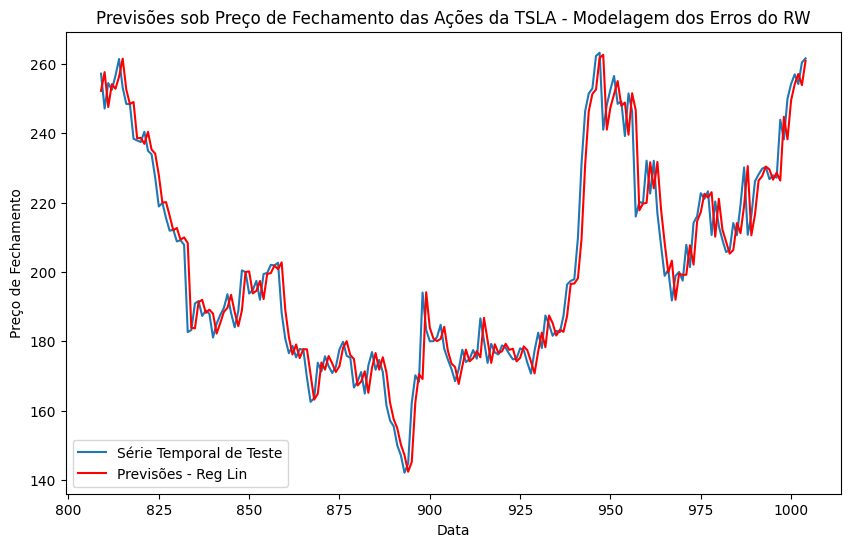

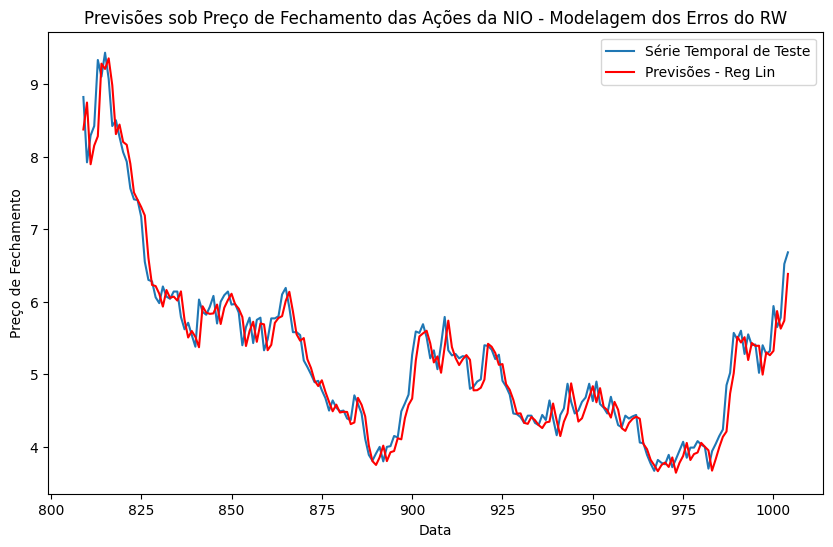

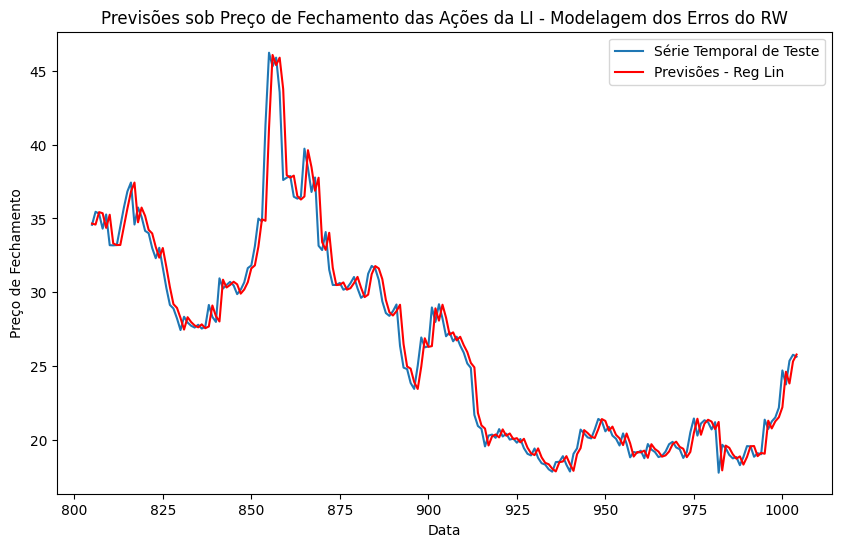

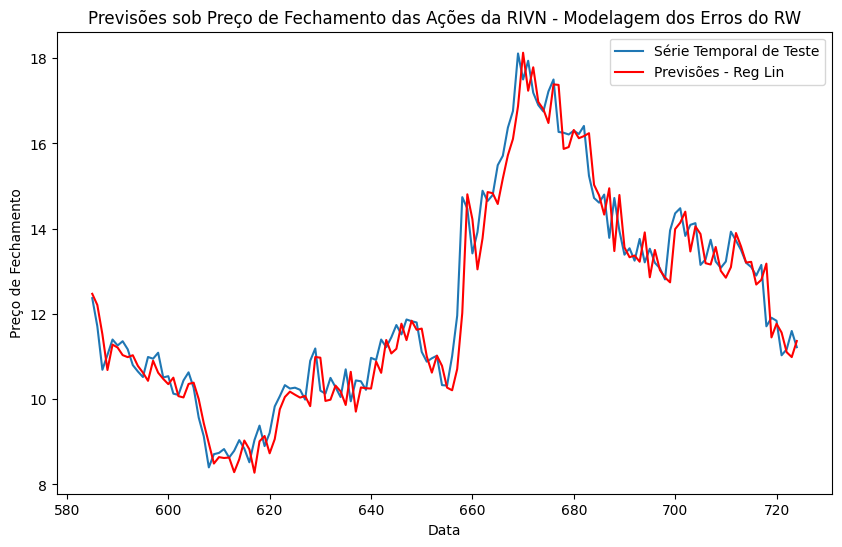

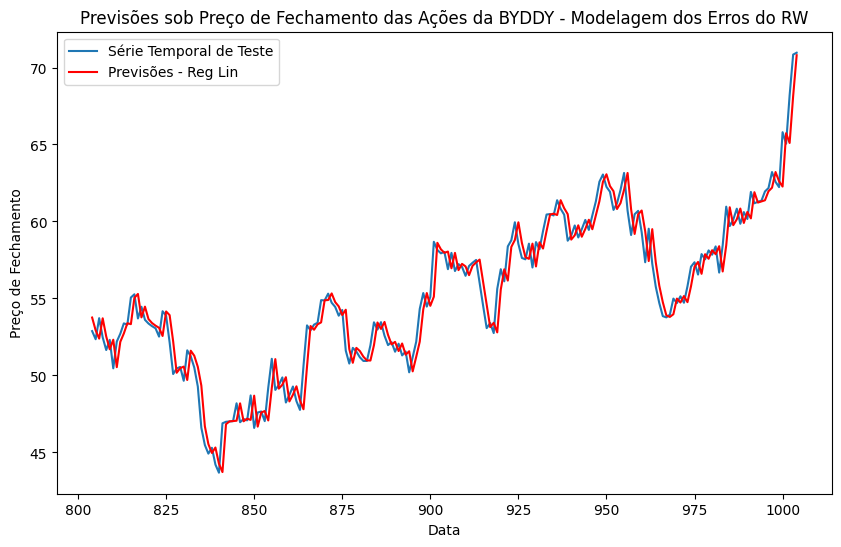

In [15]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(X_test[name].index, y_test[name], label='Série Temporal de Teste')
    plt.plot(X_test[name].index, previsoes_erw_LR[name], label='Previsões - Reg Lin', color='red')
    plt.title(f'Previsões sob Preço de Fechamento das Ações da {name} - Modelagem dos Erros do RW')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

#### Métricas e Tempos

In [16]:
metricas_erw_LR = {}
for name in tickers:
    metricas_erw_LR[name] = ax.calcular_metricas_regressao(y_test[name], previsoes_erw_LR[name])

table_metricas_erw_LR = get_table_metrics(tickers,'Reg_lin', True, metricas_erw_LR, tempos_train_erw_LR, tempos_predict_erw_LR)
table_metricas_erw_LR

,TS,Model,rw,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID,Tempo Fit (s),Tempo Predict (s)
0,TSLA,Reg_lin,True,53.313470,5.314445,0.026320,7.301607,0.939828,1.001484,0.060172,0.548718,0.022537,0.002001
1,NIO,Reg_lin,True,0.062677,0.187693,0.035071,0.250353,0.956203,1.009127,0.043797,0.430769,0.005002,0.001008
2,LI,Reg_lin,True,1.577115,0.809924,0.029852,1.255832,0.965507,1.011474,0.034493,0.517588,0.002999,0.000999
3,RIVN,Reg_lin,True,0.321108,0.417848,0.033814,0.566664,0.944140,1.073083,0.055860,0.532374,0.002998,0.000994
4,BYDDY,Reg_lin,True,1.431079,0.935825,0.017030,1.196277,0.943503,0.995384,0.056497,0.570000,0.001001,0.000994


### 4.2.1 - Modelagem das Séries Temporais

In [17]:
model_ts_LR = {}
for name in tickers:
    model_ts_LR[name] = LinearRegression()

In [18]:
tempos_train_ts_LR = fit_and_train_model(X_train, y_train, tickers, model_ts_LR)

In [19]:
tempos_predict_ts_LR, previsoes_ts_LR = predict_models(X_test, tickers, model_ts_LR)

#### GRÁFICOS

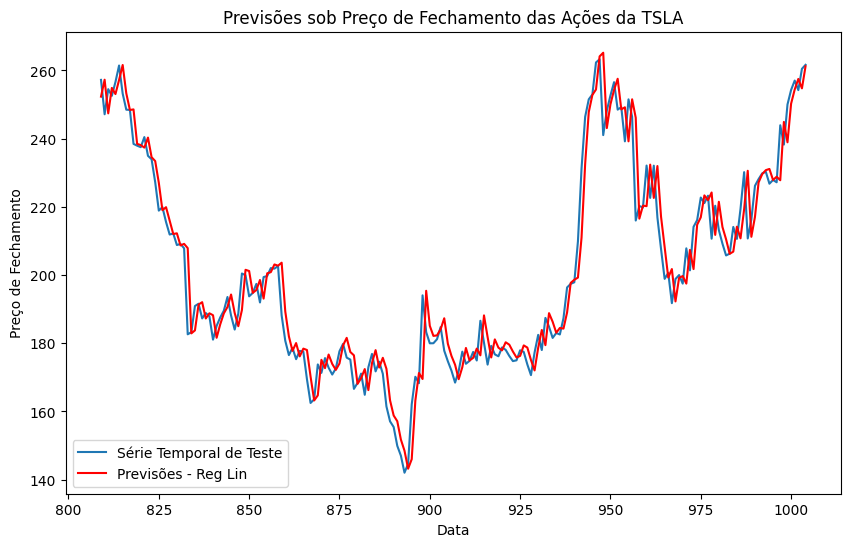

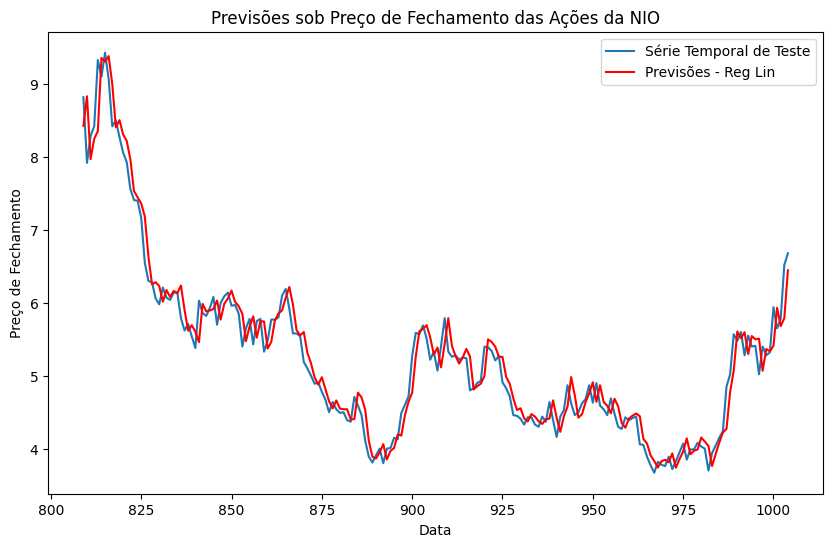

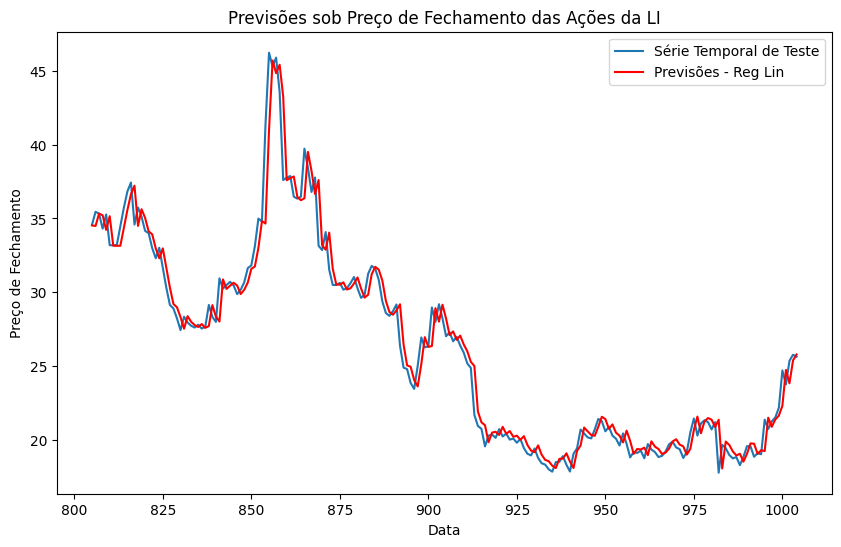

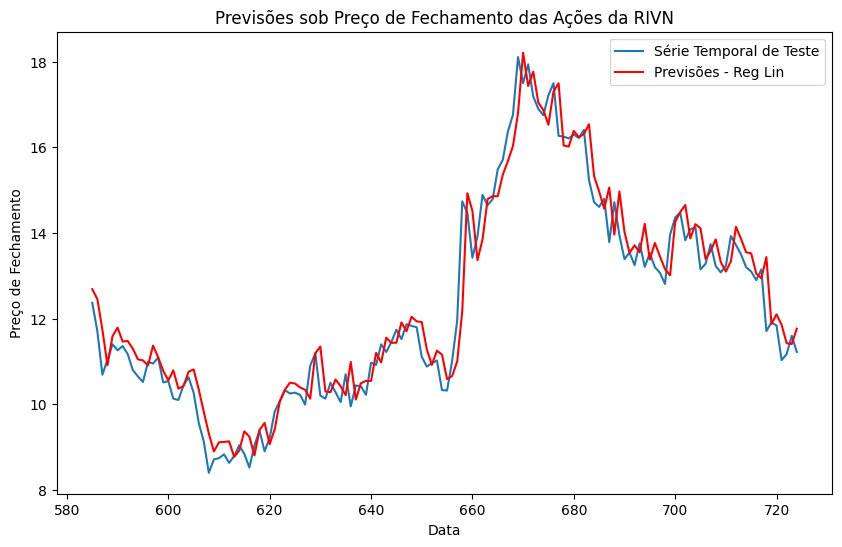

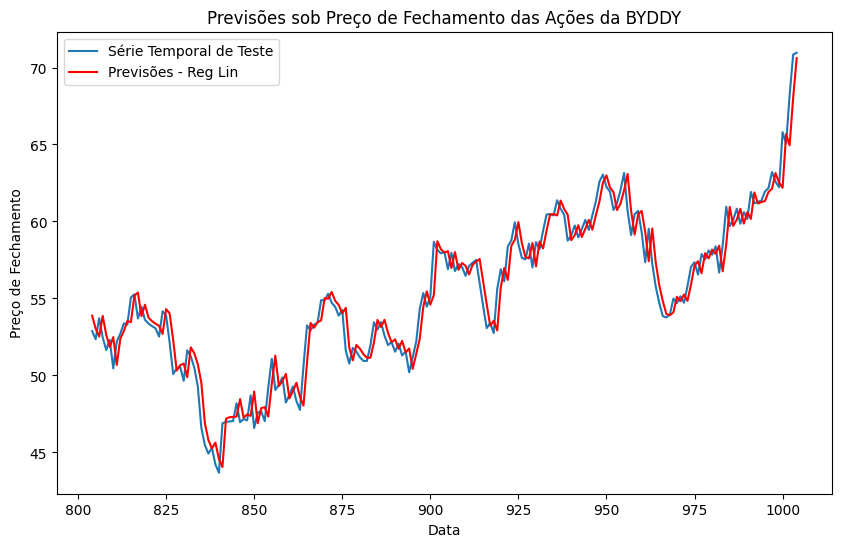

In [20]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(X_test[name].index, y_test[name], label='Série Temporal de Teste')
    plt.plot(X_test[name].index, previsoes_ts_LR[name], label='Previsões - Reg Lin', color='red')
    plt.title(f'Previsões sob Preço de Fechamento das Ações da {name}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

#### Métricas e Tempos

In [21]:
metricas_ts_LR = {}
for name in tickers:
    metricas_ts_LR[name] = ax.calcular_metricas_regressao(y_test[name], previsoes_ts_LR[name])

table_metricas_ts_LR = get_table_metrics(tickers, 'Reg_lin', False, metricas_ts_LR, tempos_train_ts_LR, tempos_predict_ts_LR)
table_metricas_ts_LR

,TS,Model,rw,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID,Tempo Fit (s),Tempo Predict (s)
0,TSLA,Reg_lin,False,53.369286,5.320864,0.026574,7.305429,0.939765,1.002582,0.060235,0.548718,0.006000,0.001994
1,NIO,Reg_lin,False,0.063012,0.192256,0.036214,0.251023,0.955968,1.018493,0.044032,0.435897,0.005995,0.002018
2,LI,Reg_lin,False,1.560841,0.819231,0.030517,1.249336,0.965863,1.001053,0.034137,0.512563,0.003020,0.001977
3,RIVN,Reg_lin,False,0.338369,0.436473,0.035932,0.581695,0.941137,1.128626,0.058863,0.510791,0.004004,0.001007
4,BYDDY,Reg_lin,False,1.438285,0.945937,0.017249,1.199285,0.943218,0.999648,0.056782,0.570000,0.002997,0.000999


### Gráficos

Abaixo temos a plotagem das previsões via modelagem da série temporal original (Vermelho) e a previsão agragada da previsão do Random Walk + previsão dos erros do Random Walk (Verde)

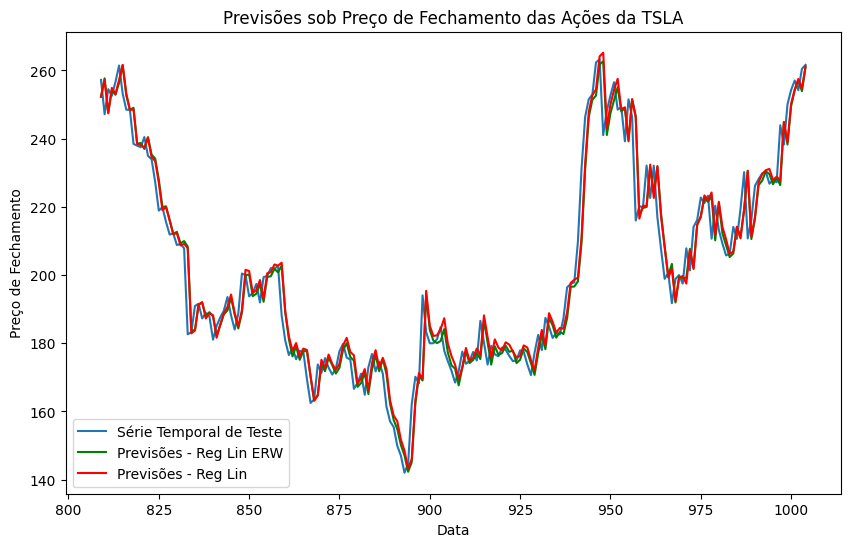

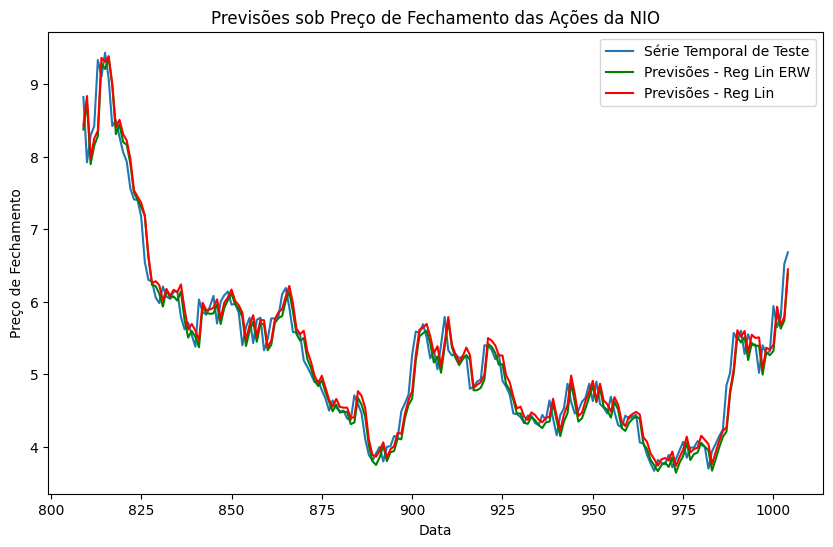

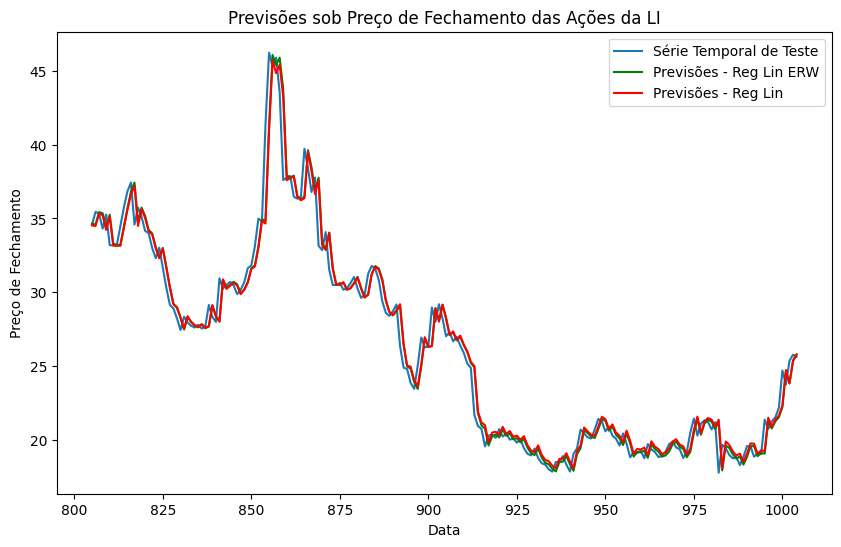

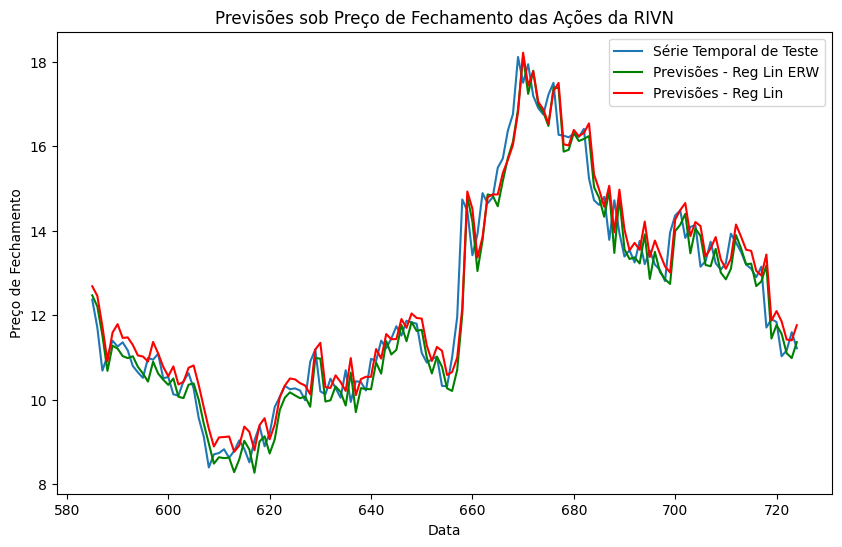

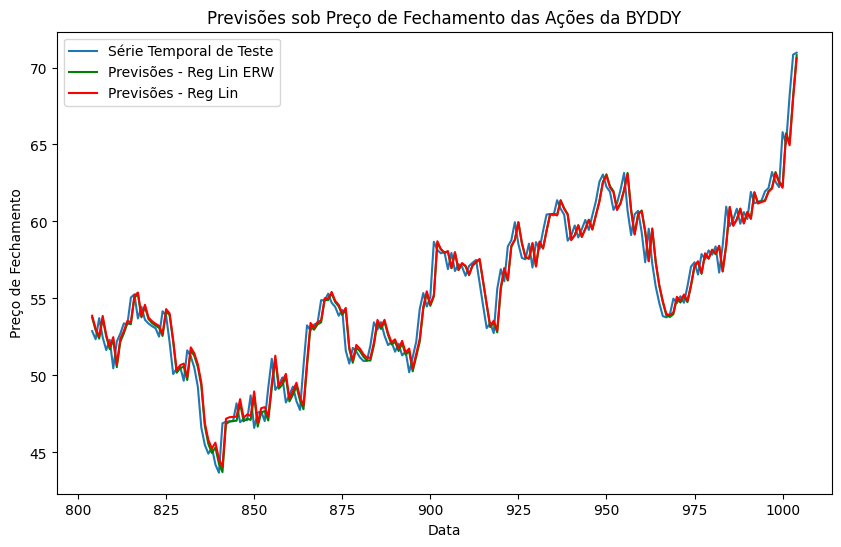

In [22]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(X_test[name].index, y_test[name], label='Série Temporal de Teste')
    plt.plot(X_test[name].index, previsoes_erw_LR[name], label='Previsões - Reg Lin ERW', color='green')
    plt.plot(X_test[name].index, previsoes_ts_LR[name], label='Previsões - Reg Lin', color='red')
    plt.title(f'Previsões sob Preço de Fechamento das Ações da {name}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

### Métricas e Tempos

In [23]:
table_metricas_LR = pd.concat([table_metricas_ts_LR, table_metricas_erw_LR], axis=0, ignore_index=True)
table_metricas_LR = table_metricas_LR.sort_values(by=['TS', 'rw']).reset_index(drop=True)
table_metricas_LR

,TS,Model,rw,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID,Tempo Fit (s),Tempo Predict (s)
0,BYDDY,Reg_lin,False,1.438285,0.945937,0.017249,1.199285,0.943218,0.999648,0.056782,0.570000,0.002997,0.000999
1,BYDDY,Reg_lin,True,1.431079,0.935825,0.017030,1.196277,0.943503,0.995384,0.056497,0.570000,0.001001,0.000994
2,LI,Reg_lin,False,1.560841,0.819231,0.030517,1.249336,0.965863,1.001053,0.034137,0.512563,0.003020,0.001977
3,LI,Reg_lin,True,1.577115,0.809924,0.029852,1.255832,0.965507,1.011474,0.034493,0.517588,0.002999,0.000999
4,NIO,Reg_lin,False,0.063012,0.192256,0.036214,0.251023,0.955968,1.018493,0.044032,0.435897,0.005995,0.002018
5,NIO,Reg_lin,True,0.062677,0.187693,0.035071,0.250353,0.956203,1.009127,0.043797,0.430769,0.005002,0.001008
6,RIVN,Reg_lin,False,0.338369,0.436473,0.035932,0.581695,0.941137,1.128626,0.058863,0.510791,0.004004,0.001007
7,RIVN,Reg_lin,True,0.321108,0.417848,0.033814,0.566664,0.944140,1.073083,0.055860,0.532374,0.002998,0.000994
8,TSLA,Reg_lin,False,53.369286,5.320864,0.026574,7.305429,0.939765,1.002582,0.060235,0.548718,0.006000,0.001994
9,TSLA,Reg_lin,True,53.313470,5.314445,0.026320,7.301607,0.939828,1.001484,0.060172,0.548718,0.022537,0.002001


## 4.3 - Modelo Arima

In [24]:
import pmdarima as pm

### Funções Auxíliares

In [25]:
def get_best_model_arima(X: dict, y: dict, tickers: list):
    models = {}
    tempos = {}
    for name in tickers:
        start_time = time.time()
        X_data = np.array(X[name].index).reshape(-1, 1)
        y_data = np.array(y[name]).reshape(-1, 1)
        models[name] = pm.auto_arima(X=X_data, y=y_data, seasonal=False, m=1, stepwise=True, trace=True)
        end_time = time.time()
        tempos[name] = end_time - start_time
    return models, tempos

In [26]:
def predict_arima(X: dict, tickers: list, models: dict):
    tempos = {}
    previsoes = {}
    for name in tickers:
        start_time = time.time()
        X_test_exog = np.array(X[name].index).reshape(-1, 1)
        previsoes[name] = models[name].predict(len(X_test_rw[name]), X = X_test_exog)
        end_time = time.time()
        tempos[name] = end_time - start_time
    return previsoes, tempos

### 4.3.1 - Modelagem do Erro do Random Walk

Na cédula seguinte obtemos nossos melhores modelos ARIMA via função AutoArima para cada uma das séries temporais.

In [27]:
model_erw_ARIMA, tempos_train_erw_ARIMA = get_best_model_arima(X_train_e, y_train_e, tickers)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5735.155, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5728.353, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5729.791, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5729.811, Time=0.34 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5731.205, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5729.838, Time=0.18 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 2.155 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2663.499, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2654.170, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2653.315, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2653.529, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2654.393, Time=0.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2655.295, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=266

Modelos com ARIMA(0,0,0) geralmente indicam que a série pode ser bem ajustada por uma constante (ou até mesmo um Random Walk). O que pode ser explicada, pois os resultados são dos modelos ARIMA da mdoelagem dos erros do Random Walk.

In [28]:
for name in tickers:
    print(f'{name}: Arima parâmetros')
    print(model_erw_ARIMA[name].order)

TSLA: Arima parâmetros
(0, 0, 0)
NIO: Arima parâmetros
(1, 0, 0)
LI: Arima parâmetros
(0, 0, 0)
RIVN: Arima parâmetros
(0, 0, 0)
BYDDY: Arima parâmetros
(0, 0, 0)


Para cada modelo ótimo obtido anteriormente, fazemos a predição da série temporal de teste DO ERRO DO RANDOK WALK, e depois fazemos a soma da previsão do random walk + previsão dos erros do RW.

In [29]:
previsoes_erros_erw_ARIMA, tempos_predict_erw_ARIMA = predict_arima(X_test_e, tickers, model_erw_ARIMA)
previsoes_erw_ARIMA = {}
for name in tickers:
    previsoes_erw_ARIMA[name] = y_test_rw[name] + previsoes_erros_erw_ARIMA[name]

#### Gráficos

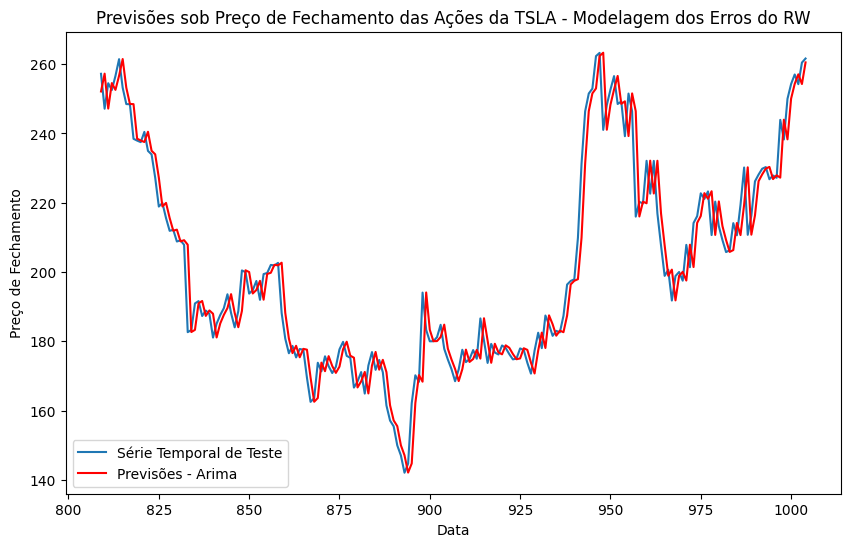

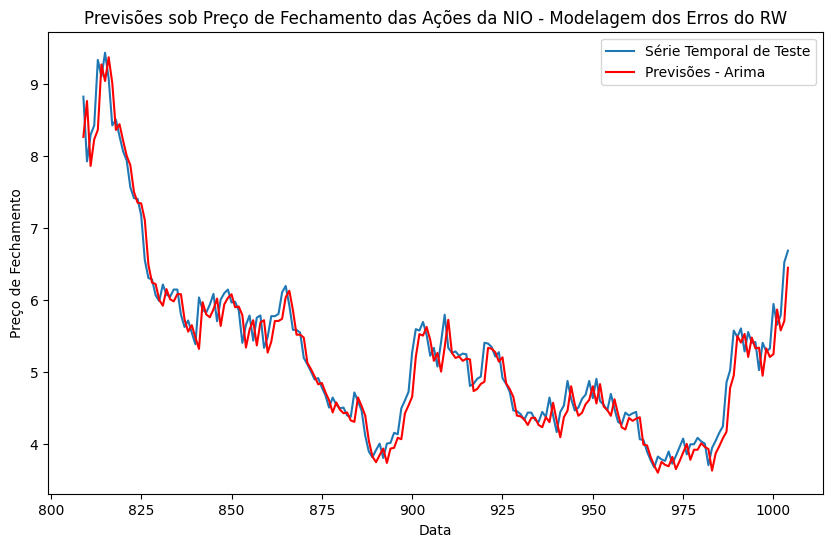

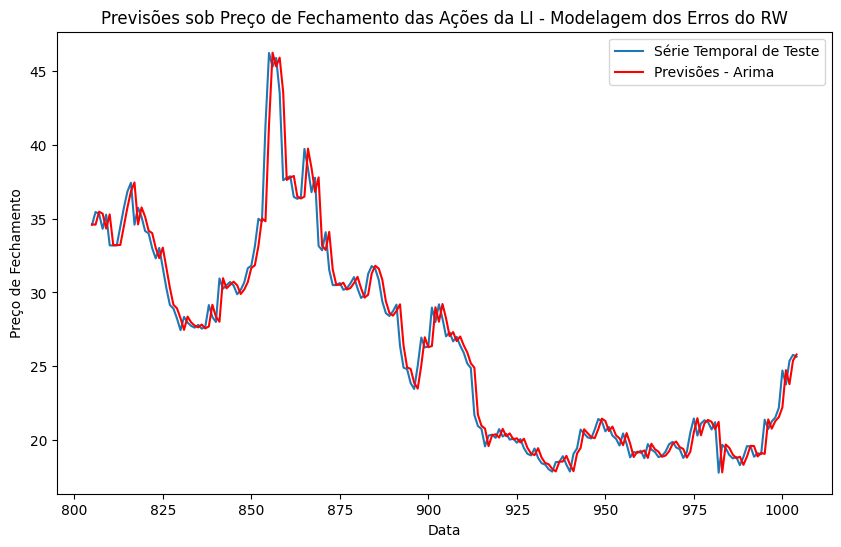

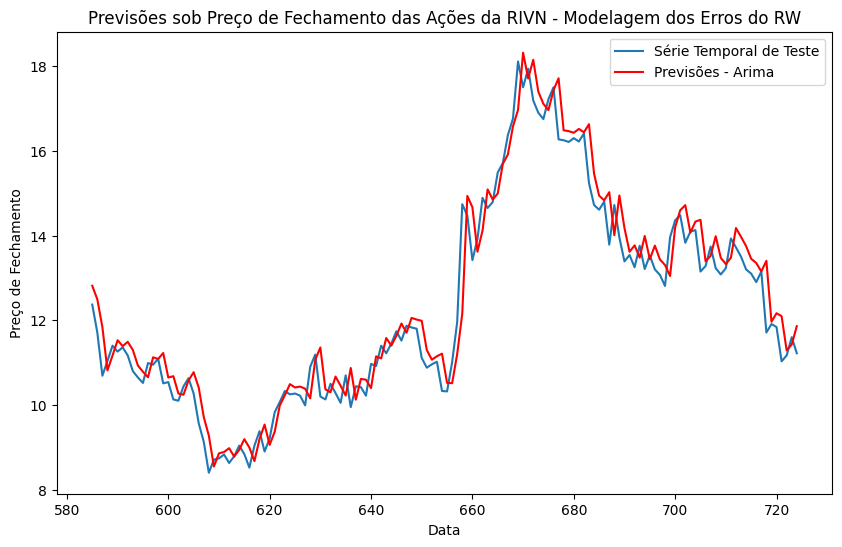

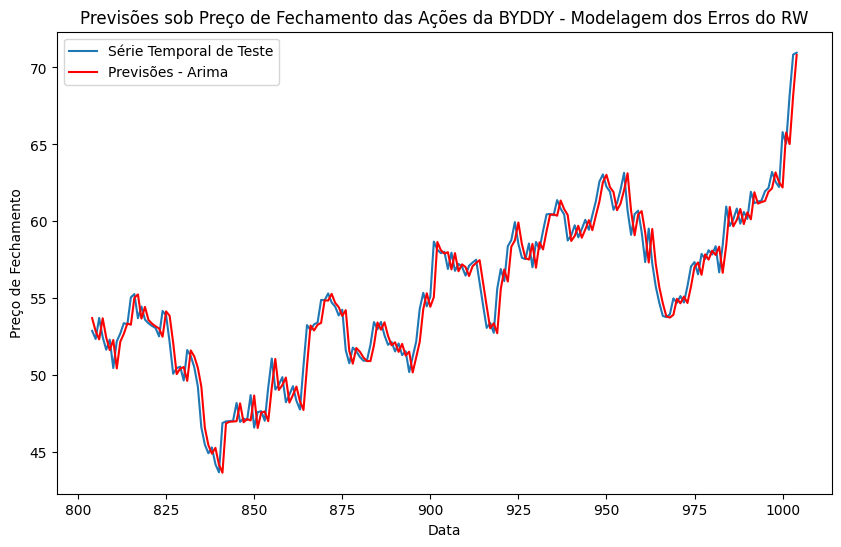

In [30]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(X_test[name].index, y_test[name], label='Série Temporal de Teste')
    plt.plot(X_test[name].index, previsoes_erw_ARIMA[name], label='Previsões - Arima', color='red')
    plt.title(f'Previsões sob Preço de Fechamento das Ações da {name} - Modelagem dos Erros do RW')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

#### Métricas e Tempos

In [31]:
metricas_erw_ARIMA = {}
for name in tickers:
    metricas_erw_ARIMA[name] = ax.calcular_metricas_regressao(y_test[name], previsoes_erw_ARIMA[name])

table_metricas_erw_ARIMA = get_table_metrics(tickers,'ARIMA', True, metricas_erw_ARIMA, tempos_train_erw_ARIMA, tempos_predict_erw_ARIMA)
table_metricas_erw_ARIMA

,TS,Model,rw,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID,Tempo Fit (s),Tempo Predict (s)
0,TSLA,ARIMA,True,53.236386,5.312283,0.026314,7.296327,0.939915,0.999897,0.060085,0.543590,2.154685,0.015014
1,NIO,ARIMA,True,0.066469,0.192751,0.036036,0.257816,0.953553,1.061867,0.046447,0.482051,1.819910,0.009977
2,LI,ARIMA,True,1.561311,0.808094,0.029814,1.249524,0.965853,1.001352,0.034147,0.507538,1.872565,0.011018
3,RIVN,ARIMA,True,0.342853,0.437801,0.035951,0.585536,0.940357,1.141321,0.059643,0.561151,2.225956,0.011009
4,BYDDY,ARIMA,True,1.443329,0.940620,0.017102,1.201386,0.943019,1.004245,0.056981,0.575000,1.340634,0.015568


### 4.3.2 - Modelagem das Séries Temporais

In [32]:
model_ts_ARIMA, tempos_train_ts_ARIMA = get_best_model_arima(X_train, y_train, tickers)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5741.104, Time=0.93 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9932.345, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8926.598, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5739.029, Time=0.45 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8132.665, Time=1.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5737.119, Time=0.20 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5738.494, Time=0.65 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5733.518, Time=0.86 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7631.219, Time=1.81 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5731.840, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8532.303, Time=0.37 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5733.507, Time=0.93 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5

__ARIMA(1,0,0):__ $$Y_t = \phi_1 Y_{t-1} + \epsilon_t$$

__ARIMA(1,1,1):__ $$Y_t - Y_{t-1} = \phi_1 (Y_{t-1} - Y_{t-2}) + \epsilon_t + \theta_1 \epsilon_{t-1}$$


In [33]:
for name in tickers:
    print(f'{name}: Arima parâmetros')
    print(model_ts_ARIMA[name].order)

TSLA: Arima parâmetros
(1, 0, 0)
NIO: Arima parâmetros
(1, 0, 0)
LI: Arima parâmetros
(1, 0, 0)
RIVN: Arima parâmetros
(1, 1, 1)
BYDDY: Arima parâmetros
(1, 0, 0)


In [34]:
previsoes_ts_ARIMA, tempos_predict_ts_ARIMA = predict_arima(X_test, tickers, model_ts_ARIMA)

As previsões para One-Step-Ahead, Two-Step-Ahead e Three-Step-Ahead é dado abaixo, essas previsões estão bem próximas com o erro bem pequeno, o que podemos considerar que essas previsões N-Step-Ahead se sairam bem. Nos gráficos que serão vistos em __Gráficos__ podemos ver que quando se afastamos mais tempos as previsões não são boas, pois o modelo não consegue capturar para isso, para esse objetivo é recorrido modelos mais complexos, tal como modelos de apredizado profundo ou os modelos de apredizado Online.

In [43]:
for name in tickers:
    print(f'\nPrevisões para {name}')
    print(f"One-Step-Ahead: {previsoes_ts_ARIMA[name][0]} | y_true: {y_test[name].iloc[0]} | Erro: {y_test[name].iloc[0] - previsoes_ts_ARIMA[name][0]}")
    print(f"Two-Step-Ahead: {previsoes_ts_ARIMA[name][1]} | y_true: {y_test[name].iloc[1]} | Erro: {y_test[name].iloc[1] - previsoes_ts_ARIMA[name][1]}")
    print(f"Three-Step-Ahead: {previsoes_ts_ARIMA[name][2]} | y_true: {y_test[name].iloc[2]} | Erro: {y_test[name].iloc[2] - previsoes_ts_ARIMA[name][2]}")


Previsões para TSLA
One-Step-Ahead: 252.08158831635487 | y_true: 257.2200012207031 | Erro: 5.138412904348257
Two-Step-Ahead: 252.0835818372892 | y_true: 247.13999938964844 | Erro: -4.94358244764075
Three-Step-Ahead: 252.0859771577364 | y_true: 254.5 | Erro: 2.4140228422635914

Previsões para NIO
One-Step-Ahead: 8.128730124430746 | y_true: 8.819999694824219 | Erro: 0.691269570393473
Two-Step-Ahead: 7.9116203603751245 | y_true: 7.920000076293945 | Erro: 0.008379715918820807
Three-Step-Ahead: 7.698565051816885 | y_true: 8.289999961853027 | Erro: 0.591434910036142

Previsões para LI
One-Step-Ahead: 34.5718451752209 | y_true: 34.56999969482422 | Erro: -0.0018454803966818645
Two-Step-Ahead: 34.54448569118452 | y_true: 35.45000076293945 | Erro: 0.9055150717549338
Three-Step-Ahead: 34.517903837350346 | y_true: 35.31999969482422 | Erro: 0.8020958574738728

Previsões para RIVN
One-Step-Ahead: 12.484048109738822 | y_true: 12.369999885559082 | Erro: -0.11404822417974003
Two-Step-Ahead: 12.3852978

As datas respectivas para os N-Step-Ahead para cada uma são:

In [63]:
for name in tickers:
    print('+---------+')
    print(f'Datas das previsões {name}')
    print(times_series[name]['Date'].iloc[X_test[name].index[0]])
    print(times_series[name]['Date'].iloc[X_test[name].index[1]])
    print(times_series[name]['Date'].iloc[X_test[name].index[2]])
    print('+---------+')

+---------+
Datas das previsões TSLA
2024-01-26
2024-01-29
2024-01-30
+---------+
+---------+
Datas das previsões NIO
2024-01-29
2024-01-30
2024-01-31
+---------+
+---------+
Datas das previsões LI
2023-12-20
2023-12-21
2023-12-22
+---------+
+---------+
Datas das previsões RIVN
2024-04-22
2024-04-23
2024-04-24
+---------+
+---------+
Datas das previsões BYDDY
2023-12-13
2023-12-14
2023-12-15
+---------+


In [44]:
n_step_ahead = []

# Itera pelos tickers para coletar previsões, valores verdadeiros e erros
for name in tickers:
    for step in range(3):  # Assume que você quer os 3 primeiros passos
        previsao = previsoes_ts_ARIMA[name][step]
        y_true = y_test[name].iloc[step]
        erro = y_true - previsao
        
        # Adiciona os dados à lista
        n_step_ahead.append({
            'Ticker': name,
            'Step': step + 1,
            'Previsao': previsao,
            'Valor_Verdadeiro': y_true,
            'Erro': erro
        })

# Converte a lista em um DataFrame
n_step_ahead = pd.DataFrame(n_step_ahead)
n_step_ahead

,Ticker,Step,Previsao,Valor_Verdadeiro,Erro
0,TSLA,1,252.081588,257.220001,5.138413
1,TSLA,2,252.083582,247.139999,-4.943582
2,TSLA,3,252.085977,254.500000,2.414023
3,NIO,1,8.128730,8.820000,0.691270
4,NIO,2,7.911620,7.920000,0.008380
5,NIO,3,7.698565,8.290000,0.591435
6,LI,1,34.571845,34.570000,-0.001845
7,LI,2,34.544486,35.450001,0.905515
8,LI,3,34.517904,35.320000,0.802096
9,RIVN,1,12.484048,12.370000,-0.114048


#### Gráficos

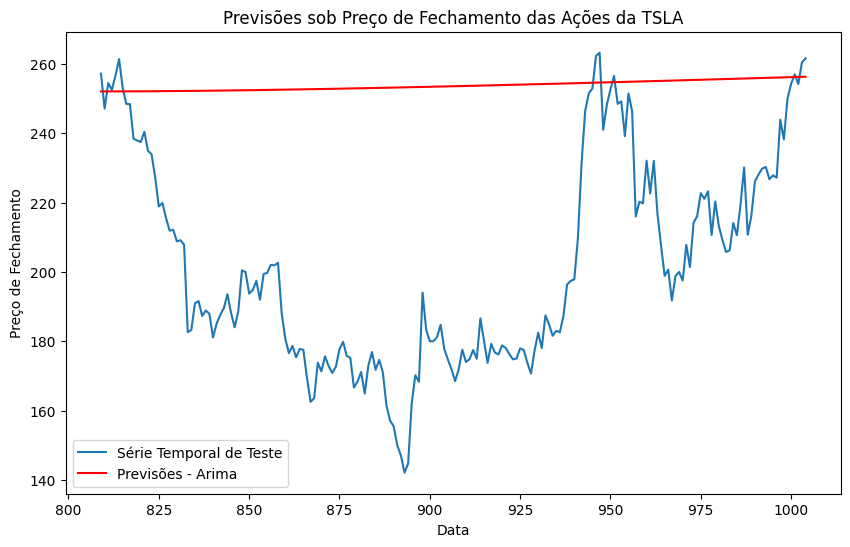

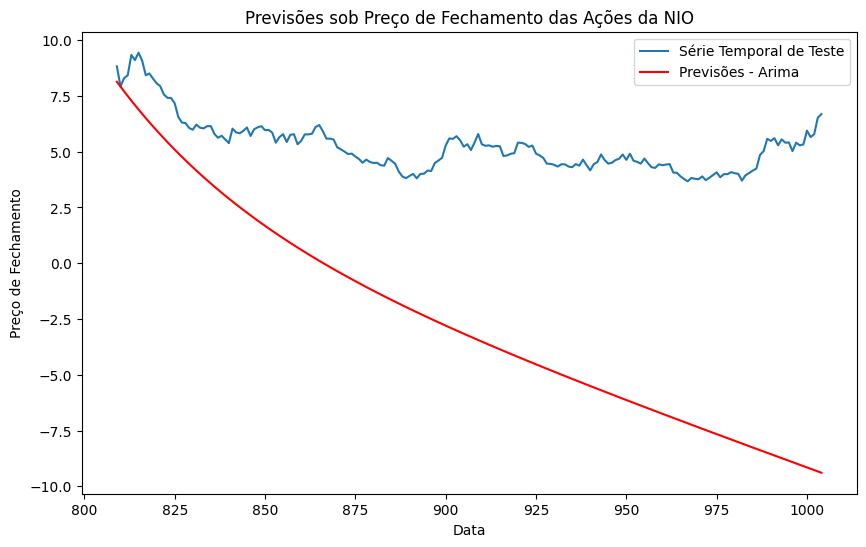

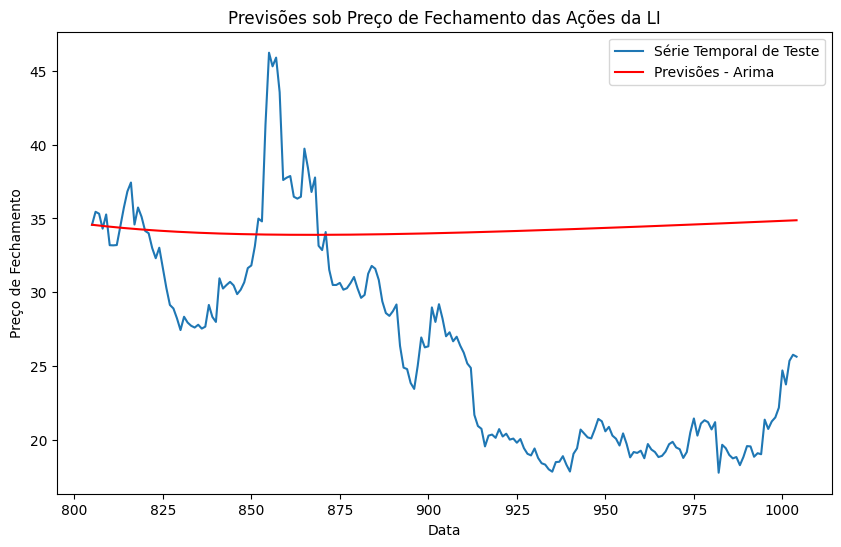

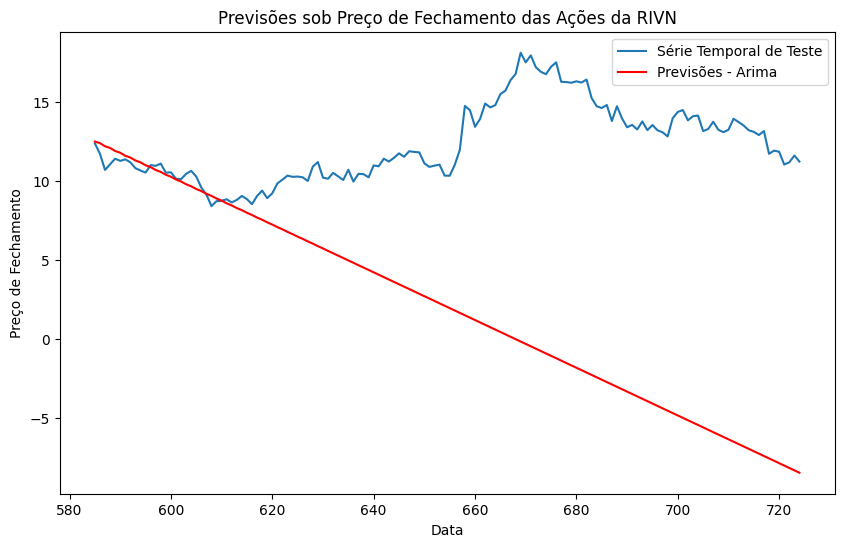

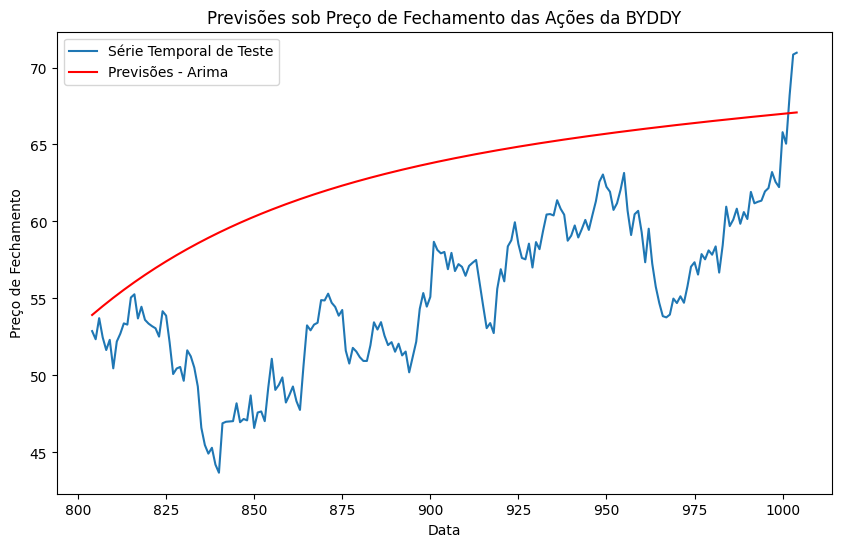

In [35]:
for name in tickers:
    plt.figure(figsize=(10, 6))
    plt.plot(X_test[name].index, y_test[name], label='Série Temporal de Teste')
    plt.plot(X_test[name].index, previsoes_ts_ARIMA[name], label='Previsões - Arima', color='red')
    plt.title(f'Previsões sob Preço de Fechamento das Ações da {name}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')
    plt.legend()
    plt.show()

#### Métricas e Tempos

Aqui as métricas para o n-step-ahead, onde $n = 1, 2, 3$.

In [49]:
metricas_ts_ARIMA = {}
for name in tickers:
    y_true = n_step_ahead[n_step_ahead['Ticker'] == name]['Valor_Verdadeiro']
    y_pred = n_step_ahead[n_step_ahead['Ticker'] == name]['Previsao']
    metricas_ts_ARIMA[name] = ax.calcular_metricas_regressao(y_true, y_pred)

table_metricas_ts_ARIMA = get_table_metrics(tickers,'ARIMA', True, metricas_ts_ARIMA, tempos_train_ts_ARIMA, tempos_predict_ts_ARIMA)
table_metricas_ts_ARIMA

,TS,Model,rw,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID,Tempo Fit (s),Tempo Predict (s)
0,TSLA,ARIMA,True,18.889934,4.165339,0.016488,4.346255,-0.041887,0.194295,1.041887,0.5,11.267054,0.014497
1,NIO,ARIMA,True,0.275906,0.430361,0.050259,0.525268,-1.022446,0.369485,2.022446,0.5,12.944583,0.011994
2,LI,ARIMA,True,0.487773,0.569819,0.016102,0.698407,-2.242687,1.849250,3.242687,0.5,12.152664,0.011001
3,RIVN,ARIMA,True,0.900804,0.761265,0.068896,0.949107,-0.886104,1.822089,1.886104,0.0,8.195618,0.008979
4,BYDDY,ARIMA,True,1.525777,1.135732,0.021532,1.235224,-3.795679,1.613632,4.795679,0.5,10.262446,0.010011


In [50]:
metricas_tso_ARIMA = {}
for name in tickers:
    metricas_tso_ARIMA[name] = ax.calcular_metricas_regressao(y_test[name], previsoes_ts_ARIMA[name])

table_metricas_tso_ARIMA = get_table_metrics(tickers,'ARIMA', True, metricas_tso_ARIMA, tempos_train_ts_ARIMA, tempos_predict_ts_ARIMA)
table_metricas_tso_ARIMA

,TS,Model,rw,MSE,MAE,MAPE,RMSE,R^2,U de THEIL,ARV,WPOCID,Tempo Fit (s),Tempo Predict (s)
0,TSLA,ARIMA,True,3561.900282,52.494938,0.285975,59.681658,-3.020091,67.065197,4.020091,0.487179,11.267054,0.014497
1,NIO,ARIMA,True,75.697595,7.786324,1.629381,8.700436,-51.896155,1238.935505,52.896155,0.446154,12.944583,0.011994
2,LI,ARIMA,True,110.953024,8.969794,0.412721,10.533424,-1.426634,71.160672,2.426634,0.527638,12.152664,0.011001
3,RIVN,ARIMA,True,166.622658,10.394513,0.777349,12.908240,-27.985765,556.950074,28.985765,0.474820,8.195618,0.008979
4,BYDDY,ARIMA,True,72.646812,7.780955,0.146115,8.523310,-1.867997,50.661724,2.867997,0.475000,10.262446,0.010011
